# Disasters Magnitude Analysis Models


## Install Requirements

In [5]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.3/151.3 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 51.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 MB 8.4 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.3
    Uninstalling pandas-2.0.3:
      Successfully uninstalled pandas-2.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pandas<2.2.2dev0,>=2.0, but you have pandas 2.2.2 which is incompatible.
google-colab 1.0.0 requires pandas==2.0.3, but you have pandas 2.2.2 which is incompatible

## Data Preparation

Historical disasters data from 2000 - 2023 was pulled from the NOAA site to use for this model

### Data Cleaning
Historical dataset was cleaned off rows without values for Longitude and Latitude columns

In [ ]:
# Clean the dataset by filtering out rows with missing or empty longitude and latitude values
import pandas as pd


def clean_disaster_csv(file):
    # Read CSV file into a DataFrame
    df = pd.read_csv(file)

    # Drop rows where longitude or latitude column has missing values
    cleaned_df = df.dropna(subset=['Longitude', 'Latitude'])

    # Write cleaned DataFrame back to a CSV file
    cleaned_df.to_csv(file, index=False)

    print(f"Cleaned disasters historical data saved to {file}")


# Example usage
if __name__ == "__main__":
    # Provide input and output file paths
    base_dir = 'dataset/'
    disaster_dataset = f"{base_dir}historical-disasters.csv"
    # Clean the CSV file
    clean_disaster_csv(disaster_dataset)


Cleaned disasters historical data saved to dataset/historical-disasters.csv


### Dataset Building
Dataset was built buy fetching climate data at the time of disasters from visual crossing API

In [ ]:
import pandas as pd
import requests
from io import StringIO
import asyncio

"""
Fetch climate data at the time of past disasters using the NOAA Climate Data API
to use as our training dataset
"""

# NOAA Climate Data API URL
API_URL = 'https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/weatherdata/history/'
API_KEY = ''  # API key


async def fetch_disasters_climate_data() -> bool:
    # Disaster types files to get data
    try:
        # Check if file alrady exist and continue fetching
        climate_dataset_df = pd.read_csv("dataset/" + "climate_data.csv")
    except Exception:
        # Else create a new dataframe
        climate_dataset_df = pd.DataFrame([["Disaster Type", "Magnitude", "Magnitude Scale", "Minimum Temperature", "Maximum Temperature", "Dew Point", "Temperature", "Wind Speed Min", "Wind Speed Max",
                                      "Wind Speed Mean", "Wind Direction", "Relative Humidity Min", "Relative Humidity Max", "Relative Humidity Mean", "Weather Type", "Precipitation", "Cloud Cover", "Sea Level Pressure", "Precipitation Cover"]])
    # Specify the index from which you want to start or continue fetching data
    start_index = 778

    # Read the CSV file and skip the rows before the start_index
    df = pd.read_csv(f'dataset/historical-disasters.csv', skiprows=range(1, start_index))
    # Iterate through the DataFrame using iterrows()
    climate_dataset_df.to_csv("dataset/" + "climate_data.csv", index=False)


    for index, row in df.iterrows():
        # Access columns using column names
        start_year = row['Start Year']
        start_month = row['Start Month']
        start_day = row['Start Day']
        end_year = row['End Year']
        end_month = row['End Month']
        end_day = row['End Day']
        if pd.isna(end_day) or pd.isna(start_day):
            continue
        if pd.isna(end_month) or pd.isna(start_month):
            continue
        print(f"Pulling historical climate data for disaster on {start_year}-{start_month}-{start_day}")
        start_date = "{}-{:02d}-{:02d}T00:00:00".format(
        start_year, int(start_month), int(start_day))
        end_date = "{}-{:02d}-{:02d}T23:59:59".format(
        end_year, int(end_month), int(end_day))

        params = {
            # first location of disaster
            "location": f"{row['Latitude']},{row['Longitude']}",
            "startDateTime": start_date,  # start date of disaster
            "endDateTime": end_date,  # end date of disaster
            "key": API_KEY,
            "aggregateHours": 24,
            "extendedStats": "true",
            "includeAstronomy": "true",
            "contentType": "csv",

        }
        climate_data_req = requests.get(API_URL, params=params)
        if climate_data_req.status_code != 200:
            print("Failed")
            continue
        print("Data pulled successfully")
        climate_data_req = climate_data_req.text
        climate_data_csv = StringIO(climate_data_req)
        data_df = pd.read_csv(climate_data_csv)
        # Filter specific columns
        filtered_df = data_df[["Minimum Temperature", "Maximum Temperature", "Dew Point", "Temperature", "Wind Speed Min", "Wind Speed Max",
                          "Wind Speed Mean", "Wind Direction", "Relative Humidity Min", "Relative Humidity Max", "Relative Humidity Mean", "Weather Type", "Precipitation", "Cloud Cover", "Sea Level Pressure", "Precipitation Cover"]]
        filtered_df.insert(0, "Disaster Type", row["Disaster Type"])
        filtered_df.insert(1, "Magnitude", row["Magnitude"])
        filtered_df.insert(2, "Magnitude Scale", row["Magnitude Scale"])

        print(index)
        filtered_df.to_csv("dataset/" + "climate_data.csv", mode='a', header=False, index=False)


    return True

if __name__ == "__main__":
    asyncio.run(fetch_disasters_climate_data())


## Dataset Cleaning
Clean rows with null and empty values

In [ ]:
import pandas as pd

def clean_climate_csv(file):
    # Read CSV file into a DataFrame
    df = pd.read_csv(file)
    # Drop null values
    df.dropna(inplace=True)
    # Write cleaned DataFrame back to a CSV file
    print(f"Cleaned climate dataset in {file}")
    df.to_csv(file, index=False)

    # Example usage
if __name__ == "__main__":
    # Modify file path to your dataset location
    base_dir = 'dataset/'
    clean_climate_csv(f"{base_dir}climate_data.csv")


Cleaned climate dataset in dataset/climate_data.csv


## Model Training, Evaluation and Visualization

###Model was trained, optimized with Intel Extension, evaluated and visualized

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Training Earthquake model
[6.431 7.4   5.662 7.032 5.275 5.315 7.839 6.15  7.312 5.659 5.082 7.094
 5.809 5.545 4.604 6.571 5.863 7.4   7.4   5.315 7.4   6.455 6.087 7.4
 7.839 6.639 6.829 6.817 7.4   6.57  5.898 6.552 6.884 7.798 6.228 6.795
 7.4   7.4   7.4   6.462]


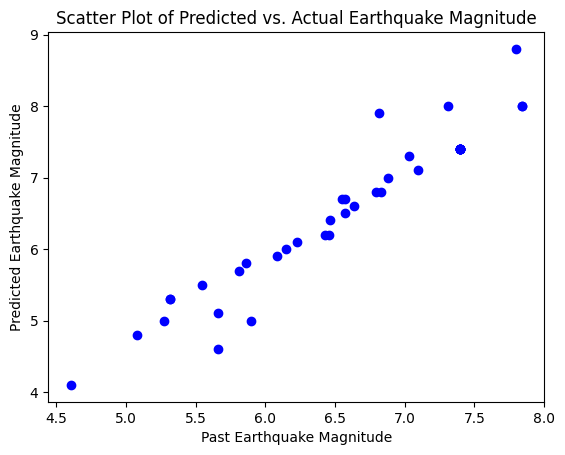

Training Flood model
[ 54152.294  69803.    150694.8   ... 159721.81    5064.1    69990.   ]


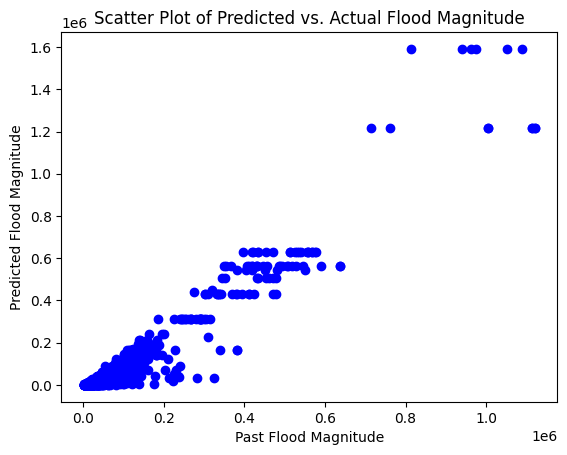

Training Storm model
[  129.26     167.4     2018.27     131.72     234.2      160.81
   170.45     163.15     168.27     168.43     169.28     168.27
   153.83     129.26    2718.87     162.1      233.55     166.715
   400.7      130.09     161.6      270.86     160.1      170.45
   386.22     213.02     413.09     179.98     169.45     161.6
   160.       246.1      129.17     246.1      167.4      913.2325
  2225.29     160.1      160.81    2225.29     226.23     234.75
   284.3      160.       167.4      163.15     234.7      160.7
   169.45     129.17    4268.75   25553.35     664.84    5282.86
   178.46     130.09     160.     25553.35     160.       161.5
   386.22     160.       169.28     145.22     160.7      169.1
   149.09     160.       389.63     226.2      170.45   25553.35
   160.       154.01   24784.05     414.5425  2434.35     229.3
   166.1625   924.36     169.28     389.63     129.82     664.92
   171.4      161.5    24784.05     281.56   24784.05     226.76
   199

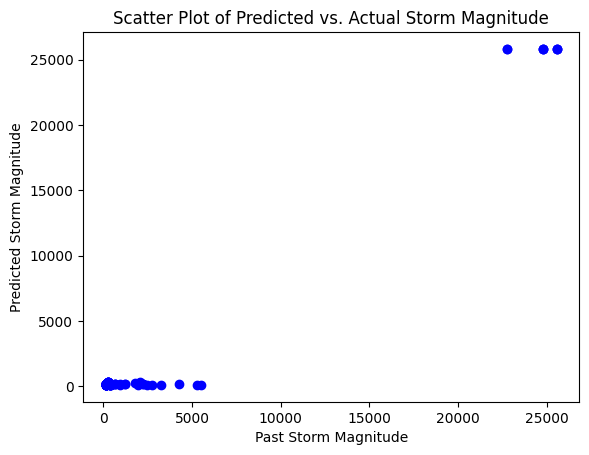

In [24]:
# Import necessary libraries
import os
import pandas as pd
#import modin.config as cfg
import numpy as np
#cfg.Engine.put('Ray')

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearnex import patch_sklearn
from sklearn import config_context
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import matplotlib.pyplot as plt

training_mse = []
training_cod = []
mse_values = []
cod_values = []

patch_sklearn()

def build_model(disaster_type):

  # Load disaster climate data
  climate_df = pd.read_csv(f"dataset/disaster types/{disaster_type}.csv")

  # Drop NaN values
  climate_df.dropna(inplace=True)

  # Encode  string values
  label_encoder = LabelEncoder()
  # climate_df['Encoded Magnitude Scale'] = label_encoder.fit_transform(climate_df['Magnitude Scale'])
  # climate_df['Encoded Disaster Type'] = label_encoder.fit_transform(climate_df['Disaster Type'])
  climate_df['Encoded Weather Type'] = label_encoder.fit_transform(climate_df['Weather Type'])


  # Prepare features and labels
  y = climate_df["Magnitude"]
  X = climate_df.drop(columns=["Magnitude", "Magnitude Scale","Disaster Type", "Weather Type"], axis=1)

  N_RUNS = 50
  TRAIN_SIZE = 0.9
  random_state = 777

  X = np.ascontiguousarray(X, dtype=np.float64)
  y = np.ascontiguousarray(y, dtype=np.float64)

  N_RUNS = 50

  # Train with Random Forest Regression
  rf = RandomForestRegressor(n_estimators=100)

  print("Training {} model".format(disaster_type))
  # cross validation
  for i in range(N_RUNS):
      # Split the data into training and testing sets
      X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_SIZE,
                                                          random_state=random_state)
      random_state += 777

      # training
      with config_context(assume_finite=True):
          model = rf.fit(X_train, y_train)

      # inference
      y_train_pred = model.predict(X_train)
      y_pred = model.predict(X_test)

      training_mse.append(mean_squared_error(y_train, y_train_pred))
      training_cod.append(r2_score(y_train, y_train_pred))

      mse_values.append(mean_squared_error(y_test, y_pred))
      cod_values.append(r2_score(y_test, y_pred))

  # Save the model to a file
  joblib.dump(model, f'model/{disaster_type}.pkl')
  print( y_train_pred)

  rf_train_mse = sum(training_mse)/len(training_mse)
  rf_train_r2 = sum(training_cod)/len(training_cod)

  rf_test_mse = sum(mse_values)/len(mse_values)
  rf_test_r2 = sum(cod_values)/len(cod_values)

  rf_result = pd.DataFrame(['Random Forest', rf_train_mse, rf_test_mse, rf_train_r2, rf_test_r2]).transpose()
  rf_result.columns = ["Method", "Training MSE", "Test MSE", "Training R2", "Test R2"]
  rf_result

  # Create the scatter plot
  plt.scatter(y_train_pred, y_train, color='b', marker='o')  # Scatter plot with blue circles

  # Customize the plot
  plt.ylabel("Predicted {} Magnitude".format(disaster_type))
  plt.xlabel("Past {} Magnitude".format(disaster_type))
  plt.title("Scatter Plot of Predicted vs. Actual {} Magnitude".format(disaster_type))

  # Show the plot
  plt.show()






def build():
  disaster_types = ["Earthquake", "Flood", "Storm"]
  for disasters in disaster_types:
    build_model(disasters)


if __name__ == "__main__":
  build()


## Inference

In [34]:
import joblib
from sklearn.preprocessing import LabelEncoder
import requests
from io import StringIO
import numpy as np
import os
import pandas as pd
import logging

"""
Run inference on model
"""

# Log server
# Configure the logging settings
logging.basicConfig(filename='waverx_analysis.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(name)s - %(message)s')

# Create a logger instance
logger = logging.getLogger('waverx_nlp')



# Load the model from file
earthquake_model = joblib.load('model/Earthquake.pkl')
flood_model = joblib.load('model/Flood.pkl')
storm_model = joblib.load('model/Storm.pkl')

# Set test Visual crossing weather API key
os.environ["API_KEY"]="R9M7HHCH4EDADEUBCU3ZENKXN"

def fetch_climate_data(location, start_date, end_date, disaster_type, api_key):
    """
    Fetching climate data at specified time to run inference
    """
    API_URL = 'https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/'

    start_date = "{}T00:00:00Z".format(start_date)
    end_date = "{}T23:59:59Z".format(end_date)

    if not api_key:
        api_key = os.getenv("API_KEY")

    params = {
        "location": location,
        "startTime": start_date,  # start date of disaster
        "endTime": end_date,  # end date of disaster
        "key": api_key,
        "include": "days",
        "contentType": "csv",
        "elements": "tempmax,tempmin,dew,temp,windspeedmin,windspeedmax,windspeedmean,winddir,humidity,conditions,precip,cloudcover,pressure,precipcover"
    }
    climate_data_req = requests.get(API_URL, params=params)
    if climate_data_req.status_code != 200:
        print("Fetching climate data failed")
        print(climate_data_req.text)
        return climate_data_req.text
    print("Data pulled successfully")
    climate_data_req = climate_data_req.text
    climate_data_csv = StringIO(climate_data_req)
    data_df = pd.read_csv(climate_data_csv)
    # Filter specific columns
    filtered_df = data_df[["tempmax", "tempmin", "dew", "temp", "windspeedmin", "windspeedmax",
                          "windspeedmean", "winddir", "humidity", "conditions", "precip", "cloudcover", "sealevelpressure", "precipcover"]]
    filtered_df.insert(0, "Disaster Type", disaster_type)
    # Calculate relative humidty min, max and mean
    humidity_min = filtered_df["humidity"] - 2
    humidity_max = filtered_df["humidity"] + 2
    humidity_mean = (humidity_max + humidity_min) / 2

    # Set data columns to dataset columns
    dataset_columns = {"tempmin": "Minimum Temperature", "tempmax": "Maximum Temperature", "dew": "Dew Point", "temp": "Temperature", "windspeedmin": "Wind Speed Min",
               "windspeedmax": "Wind Speed Max", "windspeedmean": "Wind Speed Mean", "winddir": "Wind Direction", "conditions": "Weather Type",
               "precip": "Precipitation", "cloudcover": "Cloud Cover", "sealevelpressure": "Sea Level Pressure", "precipcover": "Precipitation Cover"}

    # Ensure you're working with a copy of the DataFrame
    filtered_df = filtered_df.copy()

    # Rename columns
    filtered_df.rename(columns=dataset_columns, inplace=True)

    # Assign new columns using .loc
    filtered_df.loc[:, "Relative Humidity Min"] = humidity_min
    filtered_df.loc[:, "Relative Humidity Max"] = humidity_max
    filtered_df.loc[:, "Relative Humidity Mean"] = humidity_mean

    # Drop the "humidity" column
    filtered_df.drop(columns=["humidity"], inplace=True)

    return filtered_df

def predict(location, start_date, end_date, disaster_type, api_key):
    climate_data_df = fetch_climate_data(location, start_date, end_date, disaster_type, api_key)
    if type(climate_data_df) == str:
        print("Prediction failed")
        return climate_data_df

    # Encode  string values
    label_encoder = LabelEncoder()
    # climate_data_df['Encoded Magnitude Scale'] = label_encoder.fit_transform(climate_data_df['Magnitude Scale'])
    climate_data_df['Encoded Disaster Type'] = label_encoder.fit_transform(climate_data_df['Disaster Type'])
    climate_data_df['Encoded Weather Type'] = label_encoder.fit_transform(climate_data_df['Weather Type'])

    # Drop NaN values
    climate_data_df.dropna(inplace=True)

    X = climate_data_df.drop(columns=["Disaster Type", "Weather Type"], axis=1)

    predictions = {}
    predictions["Earthquake"] = np.array(earthquake_model.predict(X)).tolist()
    predictions["Flood"] = np.array(flood_model.predict(X)).tolist()
    predictions["Storm"] = np.array(storm_model.predict(X)).tolist()
    # if disaster_type == "Flood":
    #     # Multiply by 1600000 and divide maximum sea level pressure to get km2 value
    #     for mag in predictions:
    #         mag = round((mag * 1600000) / max(climate_data_df['Sea Level Pressure']))
    #         converted_pred.append(mag)
    # elif disaster_type == "Storm":
    #     # Multiply by 30 to get Kph value
    #     for mag in predictions:
    #         mag = round(mag * 300)
    #         converted_pred.append(mag)
    # elif disaster_type == "Earthquake":
    #     # Multiply by 9 to get richter value
    #     for mag in predictions:
    #         mag = round(mag * 9)
    #         converted_pred.append(mag)
    # else:
    #     converted_pred = predictions

    print(predictions)
    return predictions

# Example usage
if __name__ == "__main__":
    # Location in Latitude,Longitude format
    # Dates in yyyy-mm-dd format
    predict("80.41,85.9", start_date="2023-01-16", end_date="2023-01-17", disaster_type="Flood", api_key=os.getenv("API_KEY"))

Data pulled successfully
{'Earthquake': [5.909999999999999, 5.836, 6.172, 6.196999999999998, 6.280999999999999, 6.286, 6.047999999999998, 6.172000000000001, 6.179000000000002, 6.0760000000000005, 5.859000000000001, 5.811999999999999, 5.966, 6.3000000000000025, 6.303000000000002], 'Flood': [277901.36799999996, 405922.234, 372178.384, 251168.073, 282009.3909999999, 234081.68300000002, 232737.55000000002, 242069.28, 416171.05399999995, 392539.284, 236759.823, 382584.594, 236691.78, 244896.08000000002, 193615.14], 'Storm': [7883.42, 5327.59, 6097.97, 8663.06, 7632.12, 8659.23, 6869.3, 8149.04, 5838.92, 6865.900000000001, 7385.68, 6873.4400000000005, 8148.79, 8915.710000000001, 8402.25]}


## Model Server

In [ ]:
#!/usr/bin/python3
""" Flask Application """

from os import environ
from flask import Flask, jsonify, request, make_response
from flask_cors import CORS
import  prediction

# Configure the logging settings
logging.basicConfig(filename='waverx_analysis.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(name)s - %(message)s')
# Create a logger instance
logger = logging.getLogger('waverx_analysis')

app = Flask(__name__)
app.config['JSONIFY_PRETTYPRINT_REGULAR'] = True
cors = CORS(app, resources={r"/api/v1/*": {"origins": "*"}})

@app.route("/api/v1/analysis/model/waverx", methods=['POST'], strict_slashes=False)
def model_inference():
    location = request.form['location']
    start_date = request.form['startDate']
    end_date = request.form['endDate']
    disaster_type = request.form['disasterType']
    key = request.form["apiKey"]
    return jsonify(prediction.predict(location, start_date, end_date, disaster_type, key))

@app.route("/api/v1/analysis/model/waverx/status", strict_slashes=False)
def model_status():
    return jsonify({"status": "OK"})

@app.errorhandler(404)
def not_found(error):
    """ 404 Error
    ---
    responses:
      404:
        description: a resource was not found
    """
    return make_response(jsonify({'error': "Not found"}), 404)



if __name__ == "__main__":
    """ Main Function """
    host = environ.get('MODEL_HOST')
    port = environ.get('MODEL_PORT')
    if not host:
        host = '0.0.0.0'
    if not port:
        port = '5000'
    app.run(host=host, port=port, threaded=True)

